<a id="top"></a>
# Histology

## OpenVINO™ version check:
You are currently using the latest development version of Intel® Distribution of OpenVINO™ Toolkit. 

## Prerequisites
This sample requires the following:
- All files are present and in the following directory structure:
    
    - **histology.ipynb** - This Jupyter* Notebook
    - **data** - Directory to hold data
    - **python** -Directory for the Python scripts

 ### Dataset Examples
 #### How to load TF colorrectal_histology dataset

In [1]:
!pip install -U pip==21.0.1
!pip install importlib_resources
!pip install openvino-dev
!pip install tensorflow==2.5.1
!pip install openvino-tensorflow
!pip install -U tensorflow_datasets

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 454.3 MB 70 kB/s /s eta 0:00:01     |██████████████████              | 256.4 MB 105.8 MB/s eta 0:00:02
     |████████████████████████████████| 462 kB 101.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 97.9 MB/s eta 0:00:01
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
     |████████████████████████████████| 1.2 MB 112.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 100.4 MB/s eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Unins

  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from platform import python_version
print(python_version())

3.6.9


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow_datasets as tfds

print(tf.__version__)

2.5.1


In [4]:
(ds), ds_info =  tfds.load('colorectal_histology', data_dir=".", 
                                          shuffle_files=True, split='train', 
                                          with_info=True, as_supervised=True)

assert isinstance(ds, tf.data.Dataset)
print(ds_info)

tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_path='./colorectal_histology/2.0.0',
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melcher

#### Display a few examples from the dataset

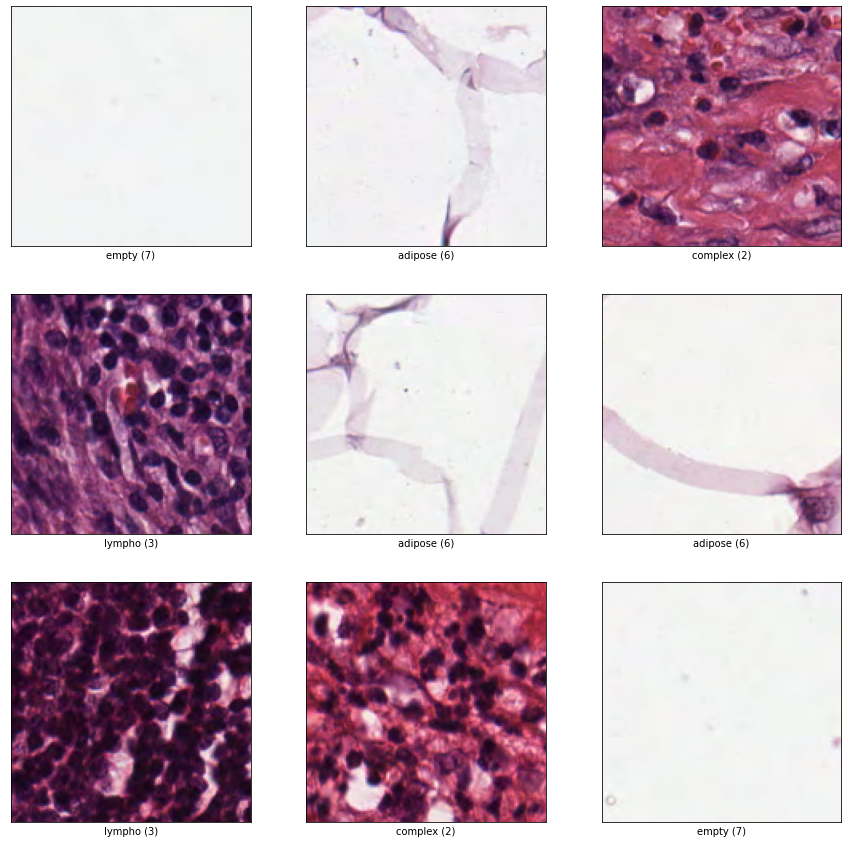

mkdir: cannot create directory ‘test_data’: File exists


In [5]:
x_key, y_key = ds_info.supervised_keys
ds_temp = ds.map(lambda x, y: {x_key: x, y_key: y})
tfds.show_examples(ds_temp, ds_info, plot_scale=5);
!mkdir test_data

#### Check the histology classification subtypes

In [6]:
ds_info.features['label'].names

['tumor',
 'stroma',
 'complex',
 'lympho',
 'debris',
 'mucosa',
 'adipose',
 'empty']

## Histology Demo
The Histology demo uses the Intel® Optimized Tensorflow to perform training and inference on input color rectal histology image dataset using OpenVINO™ integration with Tensorflow and Intel® Distribution of OpenVINO™ toolkit .  We will setup, train, run, and view the results for this application for several different hardware available on the compute nodes within the Intel® DevCloud for the Edge.  To accomplish this, we will be performing the following tasks:

1. Train the model in [Intel Optimized Tensorflow](https://software.intel.com/content/www/us/en/develop/tools/frameworks.html)
1. Run Inference using [OpenVINO™ Integration with Tensorflow](https://www.intel.com/content/www/us/en/developer/tools/devcloud/edge/build/ovtfoverview.html)
2. Use the [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) to create the inference model IR files needed to perform inference
3. Create the job file used to submit running training and inference on compute nodes
4. View results and assess performance 

### How it works
At startup, for both training and inference, the Histology application configures itself by parsing the command line arguments. Once configured, the training application loads the specified input dataset, prepares the data accordingly and runs training on the specified edge compute node. Once the model is trained, the inference app loads the inference model's IR files into the [Inference Engine](http://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) and runs inference on the specified input data to find the class of the given histology image. After the specific job is completed, the output is stored in the appropriate `results/<architecture>/` directory.  

The following sections will guide you through configuring and running the Histology demo.

### Model training for the histology images
The following sections will go through the steps to run training on the current EC2 instance. 

#### Create the job file

The job file is a [Bash](https://www.gnu.org/software/bash/) script that serves as a wrapper around the Python* executable of our application that can be executed directly on different types of edge compute node.  One purpose of the job file is to simplify running an application on different compute nodes by accepting a few arguments and then performing accordingly any necessary steps before and after running the application executable.  

For this sample, the job file we will be using is already written for you and appears in the next cell.  The job file will be submitted as if it were run from the command line using the following format:
```bash
training_job.sh <output_directory> <input_directory> <epochs> <device> <num_cores>
```
Where the job file input arguments are:
- <*output_directory*> - Output directory to use to store output files
- <*input_directory*> - Path to the input training data
- <*epochs*> - Epochs to train the model
- <*device*> - Specify the device used for training
- <*num_cores*> - If device is CPU, need to specify number of physical cores on the targeted device

Based on the input arguments, the job file will do the following:
- Change to the working directory `PBS_O_WORKDIR` where this Jupyter* Notebook and other files appear on the compute node
- Create the <*output_directory*>
- Run the application Python* executable with the appropriate command line arguments

Run the following cell to create the `training_job.sh` job file.  The [`%%writefile`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile) line at the top will write the cell contents to the specified job file `training_job.sh`.

In [9]:
%%writefile training_job.sh

# Store input arguments: <output_directory> <input_directory>
INPUT_DIRECTORY=$1
OUTPUT_DIRECTORY=$2
EPOCHS=$3
DEVICE=$4
CORES=$5

# The default path for the job is the user's home directory,
#  change directory to where the files are.
if [ ! -d "./results/" ];then
   mkdir -p ./results
fi
# Make sure that the output directory exists.
mkdir -p $OUTPUT_FILE

# Install Tensorflow 
python3.6 python/run_training.py -i $INPUT_DIRECTORY \
                               -o $OUTPUT_DIRECTORY \
                               -e $EPOCHS \
                               -d $DEVICE \
                               -c $CORES


Overwriting training_job.sh


#### Submit training job

In [10]:
!./training_job.sh colorectal_histology results/xeon/cascade_lake 25 CPU 96

mkdir: missing operand
Try 'mkdir --help' for more information.
python/run_training.py:186: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(os.path.isdir(data_directory), "Input data directory {0} does not exist!".format(data_directory))
python/run_training.py:188: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(os.path.isdir(output_dir), "Output directory {0} does not exist!".format(output_dir))
python/run_training.py:193: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(os.path.isdir(test_data_dir), "Test data directory {0} does not exist!".format(test_data_dir))
2022-03-22 19:53:21.904510: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
TensorFlow version = 2.5.1
Imported Python modules successfully.
Start training
[ INFO ] Set OMP parameters
[ INFO ] Getting data
data directory is:  colorectal_histology
[ INFO ] Load dataset 

^C


#### Trained model
Once the training job has completed, the queue system outputs the stdout and stderr streams, respecitvely.

The generated model file is written to the directory `results/<device>/checkpoints` that was specified as the output directory to the job file.  

<br><div class=danger><b>Wait!: </b>Please wait for the training job to complete before proceeding to the next step to do the OpenVINO™ model conversion and inferencing with OpenVINO™.</div>

### Inference using OpenVINO™ Integration with Tensorflow and OpenVINO™ Inference Engine
The following sections will go through the steps to run inference application for a single image using OpenVINO integration with Tensorflow and if dataset on OpenVINO Inference Engine. For viewing the results from job please refer to section 4.5

#### Inference job for single image using OpenVINO™ Integration with Tensorflow

##### Create the job file
Similarly to the training, we will run inference using OpenVINO™ integration with Tensorflow for single image.

The inference job file we will be using is already written for you and appears in the next cell.  The job file will be submitted as if it were run from the command line using the following format:
```bash
run_tensorflow_openvino.sh <device> 
```

Where the job file input arguments are:
- <*device*> - Specify the device used for inferencing

classification_ovtf_histology.py takes in multiple arguments as listed below
 - m "histology_model"
 - i "input_layer of the model>"
 - o "input_layer of the model>"
 - ip "image in Jpeg format"
 - l "label map file"
                  

Based on the input arguments, the job file will do the following:
- Create the <*output_directory*>
- Run the application Python* executable with the appropriate command line arguments



In [11]:
%%writefile run_tensorflow_openvino.sh

#!/bin/sh

DEVICE=$1

python3.6 python/classification_ovtf_histology.py -m "./results/xeon/cascade_lake/frozen_histology.pb" \
                       -i "x" \
                       -o "Identity" \
                       -ip "./data/A8D0_CRC-Prim-HE-10_002c.tif_Row_1_Col_451.jpg" \
                       -it "image" \
                       -l "./data/labels_histology.txt" \
                       -f "openvino" \
                       --input_height 150 \
                       --input_width 150 \
                       --input_mean 3 \
                       -d $DEVICE 

Overwriting run_tensorflow_openvino.sh


##### Submit  Inference job using OpenVINO™ Integration with Tensorflow
 
The inference workload will run on the CPU. It can be modified to schedule on another accelerator by passing the flag F as with a value of GPU, VPU, or VAD-M.
 
The workload images are expected to be in JPEG format. Any custom inputs need to be converted to JPEG before performing inference on them.

In [12]:
!chmod +x ./run_tensorflow_openvino.sh
!./run_tensorflow_openvino.sh "CPU"

2022-03-22 19:53:39.459880: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Available Backends:
CPU
2022-03-22 19:53:42.307166: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-22 19:53:42.311926: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-22 19:53:42.434971: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-22 19:53:42.435016: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-15-220): /proc/driver/

#### Convert the Tensorflow model to OpenVINO IR files
This workload is run on the CPU.

Run the following cell for Model Optimizer to create the model IR files. It converts the saved model trained from an edge Xeon Cascade Lake node to OpenVINO™ model format and saves it under `models/ov/<Model Precision>`. The model conversion can use either the generated savedModel or the frozen tensorflow model. Below mo_convert.sh script supports both model formats 

In [13]:
input_model="saved_model" 

In [14]:
!source mo_convert.sh $input_model

The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt-get install python3-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: ['/home/ubuntu/histology/temp_build/env/bin/python3', '-Im', 'ensurepip', '--upgrade', '--default-pip']

mo_convert.sh: line 13: env/bin/activate: No such file or directory
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 1.7 MB 4.2 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1
Defaulting to user installation because normal site-packages is not writeable
Looking in

    Uninstalling termcolor-1.1.0:
      Successfully uninstalled termcolor-1.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: opt-einsum
    Found existing installation: opt-einsum 3.3.0
    Uninstalling opt-einsum-3.3.0:
      Successfully uninstalled opt-einsum-3.3.0
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall:

In [15]:
input_model="frozen_model" 

In [16]:
!source mo_convert.sh $input_model

The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt-get install python3-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: ['/home/ubuntu/histology/temp_build/env/bin/python3', '-Im', 'ensurepip', '--upgrade', '--default-pip']

mo_convert.sh: line 13: env/bin/activate: No such file or directory
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached tensorflow-2.4.4-cp36-cp36m-manylinux2010_x86_64.whl (394.5 MB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  

    Uninstalling Werkzeug-2.0.3:
      Successfully uninstalled Werkzeug-2.0.3
  Attempting uninstall: tensorboard-plugin-wit
    Found existing installation: tensorboard-plugin-wit 1.8.1
    Uninstalling tensorboard-plugin-wit-1.8.1:
      Successfully uninstalled tensorboard-plugin-wit-1.8.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.6.0
    Uninstalling setuptools-59.6.0:
      Successfully uninstalled setuptools-59.6.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Uninstalling protobuf-3.19.4:
      Successfully uninstalled protobuf-3.19.4
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [17]:
!echo "\nAll IR files that were created:"
!find ./models/ov/FP32 -name "*.xml" -o -name "*.bin"

\nAll IR files that were created:
./models/ov/FP32/frozen_histology.xml
./models/ov/FP32/frozen_histology.bin
./models/ov/FP32/saved_model.bin
./models/ov/FP32/saved_model.xml


#### Run inference on Histology Dataset via OpenVINO™ Inference Engine
The following sections will go through the steps to run our inference application for the Histology dataset. 

##### Create the job file
Similarly to the training, we will run inference on this EC2 instance node.

The inference job file we will be using is already written for you and appears in the next cell.  The job file will be submitted as if it were run from the command line using the following format:
```bash
inference_job.sh <model_directory> <input_directory> <output_directory> <device>
```
Where the job file input arguments are:
- <*model_directory*> - OpenVINO™ model directory
- <*input_directory*> - Path to the input testing data
- <*output_directory*> - Path to store the inference output
- <*device*> - Specify the device used for inferencing

Based on the input arguments, the job file will do the following:
- Create the <*output_directory*>
- Run the application Python* executable with the appropriate command line arguments

Run the following cell to create the `inference_job.sh` job file.  The [`%%writefile`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile) line at the top will write the cell contents to the specified job file `inference_job.sh`.

In [18]:
%%writefile inference_job.sh

# Store input arguments: <model_type> <input_directory> <output_directory> <device>
MODEL_TYPE=$1
INPUT_DIRECTORY=$2
OUTPUT_DIRECTORY=$3
DEVICE=$4

# Make sure that the output directory exists.
mkdir -p $OUTPUT_DIRECTORY

# Run the inference code
python3.6 python/run_inference.py -d $DEVICE \
                                -i $INPUT_DIRECTORY \
                                -o $OUTPUT_DIRECTORY \
                                -m $MODEL_TYPE

Overwriting inference_job.sh


##### Run inference
In the cell below, we run the inference workload .

In [19]:
!chmod +x ./inference_job.sh
!./inference_job.sh FP32 test_data/testdata.npz results/xeon/cascade_lake/ CPU

2022-03-22 19:58:31.473180: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Imported Python modules successfully.
{'device': 'CPU', 'input_data': 'test_data/testdata.npz', 'model': 'FP32', 'output': 'results/xeon/cascade_lake/', 'num_instance': '1'}
[ INFO ] Creating Inference Engine
[ INFO ] Reading data from test_data/testdata.npz
[ INFO ] Loading network:
	FP32
[ INFO ] Preparing input blobs
[ INFO ] Loading model to the plugin
N, C, H, W: 1 3 150 150
[ INFO ] Current 0th class label is 2
[ INFO ] Current 1th class label is 4
[ INFO ] Current 2th class label is 1
[ INFO ] Current 3th class label is 4
[ INFO ] Current 4th class label is 0
[ INFO ] Current 5th class label is 7
[ INFO ] Current 6th class label is 6
[ INFO ] Current 7th class label is 7
[ INFO ] Current 8th class label is 7
[ INFO ] Current 9th class label is 4
[ INFO ] Current 10th class label is 5
[ INFO ] Current 11th class label is 2
[ INFO ] Curr

[ INFO ] Current 200th class label is 1
[ INFO ] Current 201th class label is 2
[ INFO ] Current 202th class label is 5
[ INFO ] Current 203th class label is 4
[ INFO ] Current 204th class label is 4
[ INFO ] Current 205th class label is 2
[ INFO ] Current 206th class label is 1
[ INFO ] Current 207th class label is 2
[ INFO ] Current 208th class label is 3
[ INFO ] Current 209th class label is 3
[ INFO ] Current 210th class label is 2
[ INFO ] Current 211th class label is 0
[ INFO ] Current 212th class label is 3
[ INFO ] Current 213th class label is 4
[ INFO ] Current 214th class label is 4
[ INFO ] Current 215th class label is 2
[ INFO ] Current 216th class label is 6
[ INFO ] Current 217th class label is 2
[ INFO ] Current 218th class label is 4
[ INFO ] Current 219th class label is 2
[ INFO ] Current 220th class label is 7
[ INFO ] Current 221th class label is 0
[ INFO ] Current 222th class label is 1
[ INFO ] Current 223th class label is 0
[ INFO ] Current 224th class label is 5


[ INFO ] Current 409th class label is 7
[ INFO ] Current 410th class label is 7
[ INFO ] Current 411th class label is 4
[ INFO ] Current 412th class label is 2
[ INFO ] Current 413th class label is 1
[ INFO ] Current 414th class label is 0
[ INFO ] Current 415th class label is 4
[ INFO ] Current 416th class label is 2
[ INFO ] Current 417th class label is 1
[ INFO ] Current 418th class label is 0
[ INFO ] Current 419th class label is 1
[ INFO ] Current 420th class label is 7
[ INFO ] Current 421th class label is 3
[ INFO ] Current 422th class label is 2
[ INFO ] Current 423th class label is 7
[ INFO ] Current 424th class label is 0
[ INFO ] Current 425th class label is 2
[ INFO ] Current 426th class label is 3
[ INFO ] Current 427th class label is 6
[ INFO ] Current 428th class label is 5
[ INFO ] Current 429th class label is 4
[ INFO ] Current 430th class label is 2
[ INFO ] Current 431th class label is 3
[ INFO ] Current 432th class label is 2
[ INFO ] Current 433th class label is 6


[ INFO ] Current 624th class label is 2
[ INFO ] Current 625th class label is 2
[ INFO ] Current 626th class label is 0
[ INFO ] Current 627th class label is 0
[ INFO ] Current 628th class label is 5
[ INFO ] Current 629th class label is 4
[ INFO ] Current 630th class label is 1
[ INFO ] Current 631th class label is 3
[ INFO ] Current 632th class label is 7
[ INFO ] Current 633th class label is 7
[ INFO ] Current 634th class label is 2
[ INFO ] Current 635th class label is 7
[ INFO ] Current 636th class label is 7
[ INFO ] Current 637th class label is 7
[ INFO ] Current 638th class label is 4
[ INFO ] Current 639th class label is 7
[ INFO ] Current 640th class label is 5
[ INFO ] Current 641th class label is 4
[ INFO ] Current 642th class label is 1
[ INFO ] Current 643th class label is 4
[ INFO ] Current 644th class label is 4
[ INFO ] Current 645th class label is 5
[ INFO ] Current 646th class label is 2
[ INFO ] Current 647th class label is 3
[ INFO ] Current 648th class label is 0


[ INFO ] Current 836th class label is 3
[ INFO ] Current 837th class label is 7
[ INFO ] Current 838th class label is 6
[ INFO ] Current 839th class label is 4
[ INFO ] Current 840th class label is 1
[ INFO ] Current 841th class label is 3
[ INFO ] Current 842th class label is 1
[ INFO ] Current 843th class label is 3
[ INFO ] Current 844th class label is 6
[ INFO ] Current 845th class label is 6
[ INFO ] Current 846th class label is 1
[ INFO ] Current 847th class label is 6
[ INFO ] Current 848th class label is 5
[ INFO ] Current 849th class label is 2
[ INFO ] Current 850th class label is 3
[ INFO ] Current 851th class label is 4
[ INFO ] Current 852th class label is 2
[ INFO ] Current 853th class label is 3
[ INFO ] Current 854th class label is 2
[ INFO ] Current 855th class label is 5
[ INFO ] Current 856th class label is 6
[ INFO ] Current 857th class label is 1
[ INFO ] Current 858th class label is 1
[ INFO ] Current 859th class label is 0
[ INFO ] Current 860th class label is 6


In [20]:
!find "results/xeon/cascade_lake/" -name "stats.txt"

results/xeon/cascade_lake/stats.txt


### View inferencing results

The output classification results for each job is written to the file `stats_<*job id*>.txt` located in the directory `results/<device>` that was specified as the output directory to the job file. Each line of the result txt file records the following information:

`index of the testing image, true class label, predicted class label`

Example of how to view the inferencing results are shown below. 


In [21]:
#For viewing results
output_file_clx = "results/xeon/cascade_lake/"+"stats"+".txt"
fd = open( output_file_clx, 'r')
print(fd.read())

0, 2, 2
1, 4, 4
2, 1, 1
3, 4, 4
4, 0, 0
5, 7, 7
6, 6, 6
7, 6, 7
8, 6, 7
9, 1, 4
10, 5, 5
11, 2, 2
12, 0, 0
13, 7, 7
14, 5, 0
15, 4, 4
16, 2, 2
17, 1, 1
18, 7, 7
19, 6, 6
20, 1, 4
21, 1, 1
22, 6, 6
23, 7, 7
24, 0, 0
25, 6, 6
26, 6, 6
27, 6, 6
28, 6, 6
29, 4, 5
30, 7, 7
31, 6, 7
32, 5, 5
33, 2, 2
34, 3, 3
35, 2, 2
36, 0, 0
37, 4, 4
38, 0, 0
39, 4, 4
40, 1, 1
41, 3, 3
42, 0, 0
43, 3, 3
44, 6, 6
45, 1, 4
46, 5, 0
47, 3, 3
48, 3, 3
49, 3, 3
50, 5, 5
51, 0, 5
52, 2, 1
53, 2, 4
54, 4, 4
55, 5, 5
56, 6, 6
57, 6, 6
58, 7, 7
59, 6, 6
60, 5, 5
61, 7, 7
62, 0, 0
63, 6, 6
64, 7, 7
65, 0, 0
66, 2, 2
67, 2, 2
68, 4, 4
69, 0, 0
70, 7, 7
71, 4, 4
72, 7, 7
73, 7, 7
74, 4, 2
75, 5, 5
76, 5, 5
77, 1, 1
78, 3, 3
79, 2, 2
80, 2, 2
81, 3, 2
82, 6, 6
83, 3, 3
84, 2, 2
85, 2, 2
86, 2, 2
87, 1, 1
88, 2, 2
89, 0, 0
90, 6, 4
91, 0, 0
92, 1, 1
93, 3, 3
94, 6, 6
95, 6, 6
96, 3, 3
97, 0, 0
98, 6, 6
99, 5, 5
100, 6, 4
101, 0, 0
102, 0, 0
103, 2, 2
104, 6, 6
105, 3, 3
106, 3, 3
107, 3, 3
108, 4, 4
109, 1, 1
110, 1, 1


## Quantization

Quantization is the process of reducing the model's precision. By performing this optimization, you can accelerate your model execution time.  

The [quantize.py](python/quantize.py) file contains quantization script and uses the [post training optimization toolkit (POT) API](https://docs.openvinotoolkit.org/latest/pot_compression_api_README.html) to reduce model's precision from FP32 to INT8. Quantization settings, such as the path to original model, path to dataset, quantization algorithm etc., which should be set via configs. ```DatasetsDataLoader``` creates quantization dataset from the sample video and loads one by one input images to POT, when quantization process starts. When quantization is finished, the INT8 model will be saved at ```'/models/ov/INT8'``` directory.

Run the following cell to create the ```quantization_job.sh``` job file. This script runs quantization and benchmarking of the quantized and non-quantized models to compare their execution time.

In [22]:
%%writefile quantization_job.sh

# Run the quantization script
python3.6 ./python/quantize.py

# Run the benchmark_app for FP32 model
benchmark_app \
        -m ./models/ov/FP32/saved_model.xml 2>/dev/null | grep Throughput | xargs echo FP32

# Run the benchmark_app for INT8 model
benchmark_app \
        -m ./models/ov/INT8/saved_model.xml 2>/dev/null | grep Throughput | xargs echo INT8

Overwriting quantization_job.sh


Run the following cell to start quantization and benchmarking of the quantized model.

In [23]:
import os
import time

In [24]:
def wait_for_job_to_finish(job_id):
    if job_id:
        print("Job submitted to the queue. Waiting for it to complete.")    
                    
        # Reading the benchmark_app results
        print('Results for FP32 and INT8 models:')
        for line in job_id:            
            if 'Throughput:' in line:
                print(line.split('\n')[0])
                      
    else:
        print("Error in job submission.")

job_id_core = get_ipython().getoutput('bash ./quantization_job.sh')
benchmarks = wait_for_job_to_finish(job_id_core)

Job submitted to the queue. Waiting for it to complete.
Results for FP32 and INT8 models:
FP32 Throughput: 724.99 FPS
INT8 Throughput: 2699.13 FPS
